Licensed to the Apache Software Foundation (ASF) under one
or more contributor license agreements.  See the NOTICE file
distributed with this work for additional information
regarding copyright ownership.  The ASF licenses this file
to you under the Apache License, Version 2.0 (the
"License"); you may not use this file except in compliance
with the License.  You may obtain a copy of the License at

  http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing,
software distributed under the License is distributed on an
"AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
KIND, either express or implied.  See the License for the
specific language governing permissions and limitations
under the License.  

In [ ]:
USING_COLAB = True
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ModuleNotFoundError:
    USING_COLAB = False

In [ ]:
import sys

if USING_COLAB is True:
    radar_path = "/content/drive/MyDrive/Radar"
else:
    radar_path = "Radar"
if radar_path not in sys.path:
    sys.path.insert(0, radar_path)

data_dir = "binary/two_sided"
model_dir = "binary/two_sided_models"
plot_dir = "binary/two_sided_plots"
roc_curve_minimum = 1e-3

In [ ]:
!pip install torcheval

In [ ]:
import torch.nn as nn
import torch
from torcheval.metrics.functional import binary_f1_score

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

confm_class_map = ["Drones", "Noise"]

In [ ]:
!pip install pennylane

In [ ]:
import pennylane as qml

# Define the quantum circuit using PennyLane
n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode0(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

@qml.qnode(dev)
def qnode1(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

@qml.qnode(dev)
def qnode2(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

@qml.qnode(dev)
def qnode3(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

# Define the QLayer
n_layers = 3
weight_shapes = {"weights": (n_layers, n_qubits)}


class HybridRadarBinaryClassifier(nn.Module):
  def __init__(self, conf):
        super(HybridRadarBinaryClassifier, self).__init__()

        # i/p shape - (batch_size, Channel_in, Height_in, Width_in) - (2, 16, 251)
        self.conv1 = nn.Conv2d(2, 16, (3,3), padding =1) # o/p shape - (16, 16, 251)
        self.IN1 = nn.InstanceNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2, padding =1) # o/p shape (16, 8, 126)
        self.conv2 = nn.Conv2d(16, 32, (5,5), padding = 2) # o/p shape (32, 8, 126)
        self.IN2 = nn.InstanceNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2) # o/p shape (32, 4, 63)

        #quantum layer
        self.qlayer1 = qml.qnn.TorchLayer(qnode0, weight_shapes)
        self.qlayer2 = qml.qnn.TorchLayer(qnode1, weight_shapes)
        self.qlayer3 = qml.qnn.TorchLayer(qnode2, weight_shapes)
        self.qlayer4 = qml.qnn.TorchLayer(qnode3, weight_shapes)

        #fully connected layers
        self.fc1 = nn.Linear( 32 * 12 * 21 , 120)
        self.fc2 = nn.Linear( 120 , 20 )
        self.fc3 = nn.Linear( 20 , 2)  # o/p shape should be (batch_size,5,1,1)

        self.drop = nn.Dropout2d(p=0.5)
        self.relu = nn.LeakyReLU()

  def forward(self, x):
        # i/p shape - (batch_size, Channel_in, Height_in, Width_in) - (2, 16, 251)
        x = self.pool1(self.relu(self.IN1(self.conv1(x))))
        x = self.drop(x)
        x = self.pool2(self.relu(self.IN2(self.conv2(x))))
        x = self.drop(x)
        #flatten
        x = x.view(-1, 32 * 12 * 21) # x = torch.flatten(x, start_dim=1
        #FC layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))

        # qlayers connected in parallel
        # Make sure the values are normalised to lie in the range [0,pi]
        # since the qnodes are using angle embedding
        x = F.normalize(x) * np.pi
        x_1, x_2, x_3, x_4 = torch.split(x, 5, dim=1)
        x_1 = self.qlayer1(x_1)
        x_2 = self.qlayer2(x_2)
        x_3 = self.qlayer3(x_3)
        x_4 = self.qlayer4(x_4)
        x = torch.cat([x_1, x_2, x_3, x_4], axis=1)

     # if we want qlayers connected serially?
       # x = self.qlayer1(x)
       # x = self.qlayer2(x)
       # x = self.qlayer3(x)
       # x = self.qlayer4(x)

        x = self.fc3(x)
        return x


In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as ds
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay


model_path = f"{radar_path}/{model_dir}"
plot_path = f"{radar_path}/{plot_dir}"
os.system(f"mkdir -p {model_path}")
os.system(f"mkdir -p {plot_path}")


def dataloader(file_extension):
    data = np.load(file_extension)
    return data


def plot_spectrogram(sp):
    fig, axs = plt.subplots(2, ncols=1, figsize=(14,3))

    axs[0].imshow(sp[0])
    axs[1].imshow(sp[1])

    plt.tight_layout()
    plt.show()


def plot_sklearn_roc_curve(y_real, y_pred, snr, plot_file=None,
                           pos_label=None, remove_zeros=False):
    fpr, tpr, _ = roc_curve(y_real, y_pred, pos_label=pos_label)
    if remove_zeros is True:
        zero_indices = np.where(np.isclose(fpr, 0))
        fpr = np.delete(fpr, zero_indices)
        tpr = np.delete(tpr, zero_indices)
    else:
        fpr[np.isclose(fpr,0)] = 1e-5
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=None).plot()
    roc_display.figure_.set_size_inches(5,5)
    roc_display.ax_.set_xscale("log")
    roc_display.ax_.set_xlim(roc_curve_minimum, 1.0)
    roc_display.ax_.set_xlabel("False Positive Rate")
    line = plt.plot(np.geomspace(roc_curve_minimum,1.0), np.geomspace(roc_curve_minimum,1.0), color='g')
    line[0].set_label("Chance")
    roc_display.line_.set_label("Hybrid detector")
    roc_display.ax_.legend()
    plt.tight_layout()
    if plot_file is not None:
        plt.savefig(plot_file)
    else:
        plt.show()


def train(conf, trainLoader, device):

    net = HybridRadarBinaryClassifier(conf).to(device)

    optim = torch.optim.AdamW(net.parameters(), lr=conf["learning_rate"])
    criterion = nn.CrossEntropyLoss().to(device)

    for x in range(conf["epochs"]):

        net.train()

        for i, data in enumerate(trainLoader):
            # plot_spectrogram(torch.squeeze(data[0]))
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optim.zero_grad()

            outputs = net(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optim.step()
            loss_val = loss.item()

        print('Train Epoch: {} Loss: {:.6f}'.format(x, loss_val))
        if x > conf['min_epochs'] and loss_val < conf['loss_threshold']:
            break

    if conf['save_model'] is True:
        print(f"Saving model state to {conf['model_path']}")
        torch.save(net.state_dict(), conf['model_path'])


def test(conf, testLoader, device, pos_label=None, plot_dir=None):

    # load model state
    net = HybridRadarBinaryClassifier(conf).to(device)
    net.load_state_dict(torch.load(conf['model_path']))
    net.eval()

    correct = 0
    total = 0
    testloss = 0
    predicted = None
    probabilities = None
    target = None

    loss_fn = nn.CrossEntropyLoss().to(device)

    confm = np.zeros((2, 2), dtype=int)
    for i, data in enumerate(testLoader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        if target is None:
            target = labels
        else:
            target = torch.cat((target, labels))

        outputs = net(inputs.float())
        loss = loss_fn(outputs, labels)
        testloss += loss.item()

        partial_probabilities = nn.Softmax(dim=1)(outputs.data)
        if probabilities is None:
            probabilities = partial_probabilities
        else:
            probabilities = torch.cat((probabilities, partial_probabilities))

        _, partial_predicted = torch.max(outputs.data, 1)
        if predicted is None:
            predicted = partial_predicted
        else:
            predicted = torch.cat((predicted, partial_predicted))

    if pos_label is None:
        pos_label = 0
    plot_file = None
    if plot_dir is not None:
        plot_file = f"{plot_dir}/hybrid_detector_roc_model-{model_snr}_signal-{conf['SNR']}.pdf"
    plot_sklearn_roc_curve(target, probabilities[:,pos_label], conf['SNR'],
                           plot_file=plot_file, pos_label=pos_label)

    confm = confusion_matrix(target, predicted)
    print(f"{confm=}")
    if conf['plot_confusion'] is True:
        plt.close()
        fig, ax = plot_confusion_matrix(conf_mat=confm,
                                        show_normed=True,
                                        colorbar=True,
                                        class_names=confm_class_map)
        plt.tight_layout()
        plt.show()

    f1 = binary_f1_score(predicted, target)
    print(f"{f1=}")


### Training Code

In [ ]:
#for snr, threshold in zip([20, 15, 10, 5, 0, -5, -10],
#                          [0.01, 0.01, 0.01, 0.05, 0.1, 0.1, 0.1]):
for snr, threshold in zip([-5],[0.01]):
    conf = {}
    conf['f_s'] = 10_000
    conf['SNR'] = snr
    conf['batch_size'] = 8
    conf['epochs'] = 200
    conf['min_epochs'] = 50
    conf['learning_rate'] = 0.005
    conf['loss_threshold'] = threshold
    conf['save_model'] = True
    conf['model_path'] = f"{model_path}/hybrid-parallel-binary-model-{snr}.pt"

    trainset_root = f"{radar_path}/{data_dir}/trainset/{conf['f_s']}fs/{conf['SNR']}SNR"
    trainds = ds.DatasetFolder(trainset_root, dataloader, extensions=("npy",))
    trainLoader = torch.utils.data.DataLoader(trainds, conf["batch_size"], shuffle=True, num_workers=2)
    # By default the DatasetFolder assigns labels based on the alphabetically
    # sorted list of sub-folder names. Run the following code to see the
    # results.
    #
    # class_list, class_dict = trainds.find_classes(dataset_root_template)
    # print(f"{class_list=}")
    # print(f"{class_dict=}")

    print(f"SNR: {snr} dB")
    train(conf, trainLoader, device)

SNR: -5 dB
Train Epoch: 0 Loss: 0.601813
Train Epoch: 1 Loss: 0.484670
Train Epoch: 2 Loss: 0.029134
Train Epoch: 3 Loss: 0.044373
Train Epoch: 4 Loss: 0.143806
Train Epoch: 5 Loss: 0.027106
Train Epoch: 6 Loss: 0.208012
Train Epoch: 7 Loss: 0.089552
Train Epoch: 8 Loss: 0.111366
Train Epoch: 9 Loss: 0.243489
Train Epoch: 10 Loss: 0.023294
Train Epoch: 11 Loss: 0.020108
Train Epoch: 12 Loss: 0.017939
Train Epoch: 13 Loss: 0.063666
Train Epoch: 14 Loss: 0.133705
Train Epoch: 15 Loss: 0.032742
Train Epoch: 16 Loss: 0.143812
Train Epoch: 17 Loss: 0.018238
Train Epoch: 18 Loss: 0.116738
Train Epoch: 19 Loss: 0.039479
Train Epoch: 20 Loss: 0.042394
Train Epoch: 21 Loss: 0.142976
Train Epoch: 22 Loss: 0.210765
Train Epoch: 23 Loss: 0.282801
Train Epoch: 24 Loss: 0.038932
Train Epoch: 25 Loss: 0.044210
Train Epoch: 26 Loss: 0.072579
Train Epoch: 27 Loss: 0.300077
Train Epoch: 28 Loss: 0.262072
Train Epoch: 29 Loss: 0.073470
Train Epoch: 30 Loss: 0.038793
Train Epoch: 31 Loss: 0.252018
Train E

### Model Evaluation

SNR: -5 dB


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


confm=array([[4985,   15],
       [ 392, 4608]])


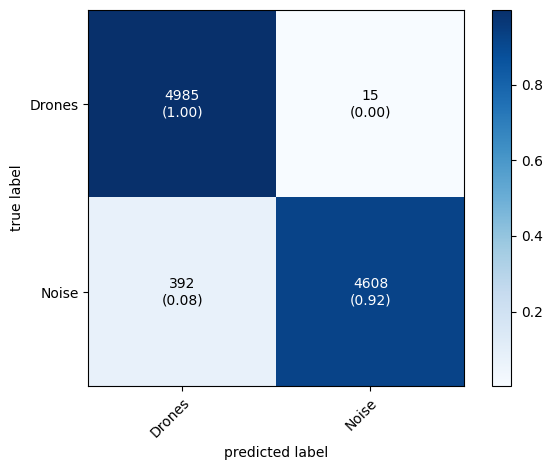

f1=tensor(0.9577)
SNR: -10 dB


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


confm=array([[4854,  146],
       [ 294, 4706]])


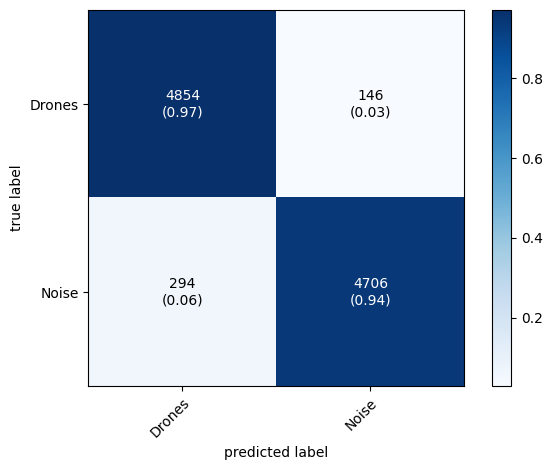

f1=tensor(0.9553)
SNR: -15 dB


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


confm=array([[4446,  554],
       [ 231, 4769]])


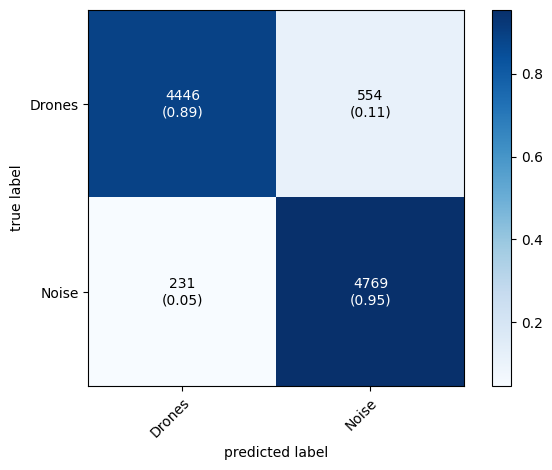

f1=tensor(0.9240)
SNR: -20 dB


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


confm=array([[3822, 1178],
       [ 180, 4820]])


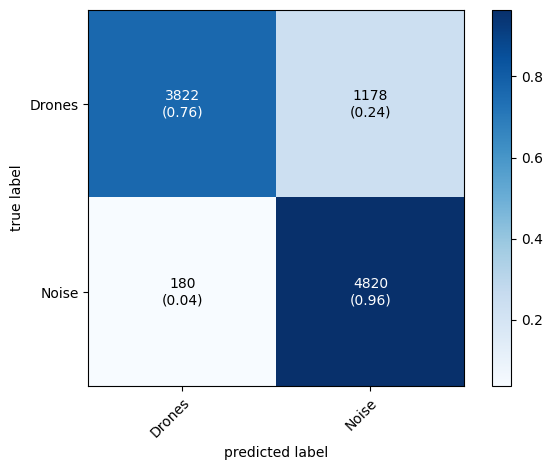

f1=tensor(0.8765)


In [ ]:
model_snr = -5
#for snr in [20, 15, 10, 5, 0, -5, -10, -15, -20]:
for snr in [-5, -10, -15, -20]:
    conf = {}
    conf['f_s'] = 10_000
    conf['SNR'] = snr
    conf['batch_size'] = 8
    conf['epochs'] = 10
    conf['learning_rate'] = 0.01
    conf['plot_confusion'] = True
    conf['model_path'] = f"{model_path}/hybrid-parallel-binary-model-{model_snr}.pt"

    testset_root = f"{radar_path}/{data_dir}/testset/{conf['f_s']}fs/{conf['SNR']}SNR"
    testds = ds.DatasetFolder( testset_root, dataloader, extensions=("npy",))
    testLoader = torch.utils.data.DataLoader( testds, conf["batch_size"], shuffle=True, num_workers=2)

    class_list, class_dict = testds.find_classes(testset_root)

    print(f"SNR: {snr} dB")
    test(conf, testLoader, device, pos_label=class_dict['drones'], plot_dir=plot_path)

### Generate Plots from Model Evaluation Results

Model evaluation for SNR=-5
Model evaluation for SNR=-10
Model evaluation for SNR=-15
Model evaluation for SNR=-20



F1 Scores for Model Trained with SNR=-5

Signal SNR      F1 Score
------------------------
   -5   :     0.952
  -10   :     0.927
  -15   :     0.832
  -20   :     0.748





/tmp/ipykernel_3991/1553014712.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


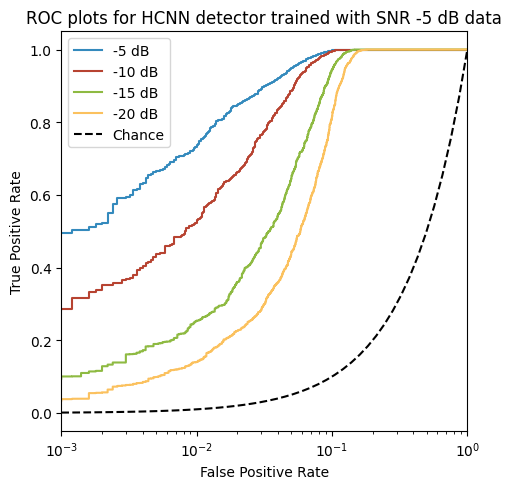

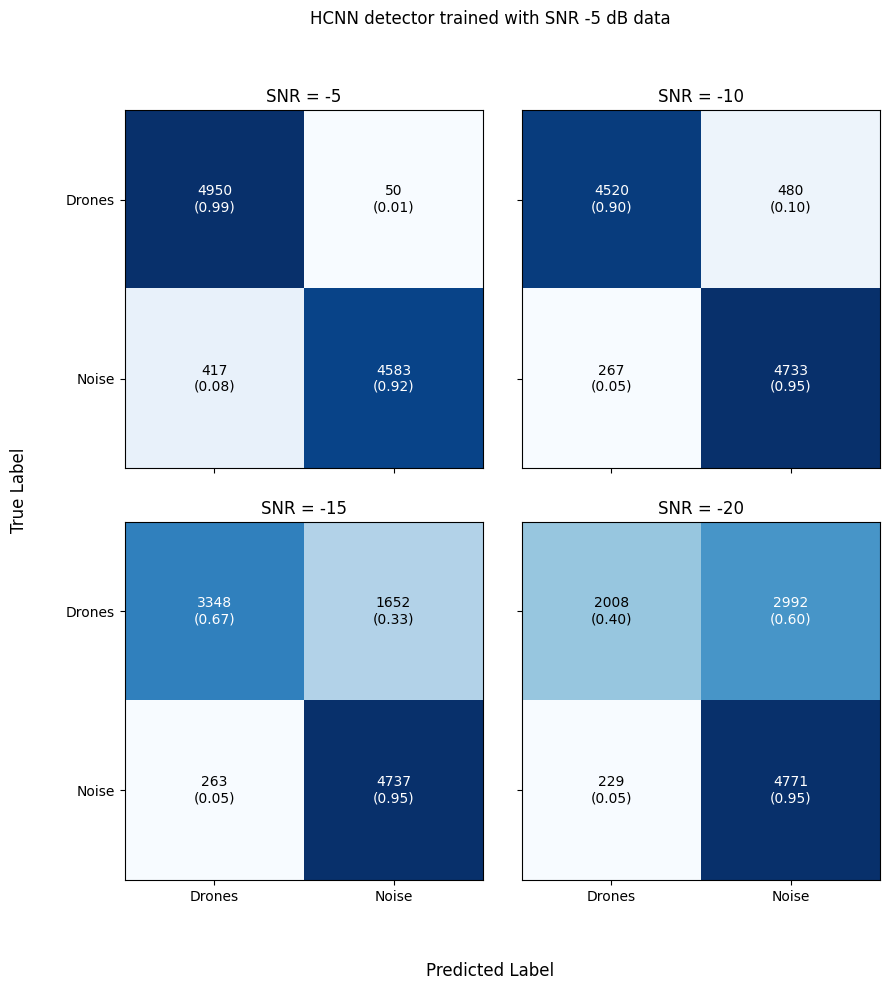

In [ ]:
from itertools import cycle

def evaluate_model(model, loader):
    target = None
    probabilities = None
    predicted = None
    testloss = 0

    for i, data in enumerate(loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        if target is None:
            target = labels
        else:
            target = torch.cat((target, labels))

        outputs = model(inputs.float())
        loss = loss_fn(outputs, labels)
        testloss += loss.item()

        partial_probabilities = nn.Softmax(dim=1)(outputs.data)
        if probabilities is None:
            probabilities = partial_probabilities
        else:
            probabilities = torch.cat((probabilities, partial_probabilities))

        _, partial_predicted = torch.max(outputs.data, 1)

        if predicted is None:
            predicted = partial_predicted
        else:
            predicted = torch.cat((predicted, partial_predicted))
    return target, predicted, probabilities


def calc_model_f1_scores(pred, real):
    f1_scores = {}
    for idx, snr in enumerate(test_snrs):
        f1_scores[snr] = float(binary_f1_score(pred[idx], real[idx]).numpy())
    return f1_scores


def print_f1_scores(mdl_snr, pred, real):
    f1_scores = calc_model_f1_scores(pred, real)

    print("\n\n")
    print(f"F1 Scores for Model Trained with SNR={mdl_snr}\n")
    print("Signal SNR      F1 Score")
    print("------------------------")
    for snr, f1 in f1_scores.items():
        print(f"{snr:^8}:     {f1:.3f}")
    print("\n\n")


def plot_confusion_matrices(mdl_snr, snrs, pred, real):
    nrows = 2
    ncols = 2
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(nrows=nrows, ncols=ncols, hspace=0.15, wspace=0.05)
    axs = gs.subplots(sharex='col', sharey='row')
    for idx, snr in enumerate(confusion_snrs):
        col = idx % nrows
        row = idx // ncols
        confm = confusion_matrix(target[idx], predicted[idx])
        plot_confusion_matrix(conf_mat=confm,
                              figure=fig,
                              axis=axs[row, col],
                              show_normed=True,
                              colorbar=False,
                              class_names=confm_class_map)
        axs[row, col].set_title(f"SNR = {snr}")
        axs[row, col].label_outer()
    tick_marks = np.arange(len(confm_class_map))
    for col in range(ncols):
        axs[1,col].set_xticks(tick_marks, confm_class_map, rotation=0, ha="center")
    for row in range(nrows):
        axs[row, 0].set_yticks(tick_marks, confm_class_map)
    axs[1,1].set_xlabel("")
    axs[1,1].set_ylabel("")
    fig.supxlabel("Predicted Label")
    fig.supylabel("True Label")
    fig.suptitle(f"HCNN detector trained with SNR {mdl_snr} dB data")
    plt.tight_layout()
    plt.savefig(f"{plot_path}/hybrid_detector_confusion_snr_{mdl_snr}.pdf")


# ---------- Run model evaluations and save results

model_snr = -5
#test_snrs = [20, 15, 10, 5, 0, -5, -10, -15, -20]
test_snrs = [-5, -10, -15, -20]

target = {}
predicted = {}
probabilities = {}
class_dict = None

for idx, snr in enumerate(test_snrs):
    conf = {}
    conf['f_s'] = 10_000
    conf['SNR'] = snr
    conf['batch_size'] = 8
    conf['epochs'] = 10
    conf['learning_rate'] = 0.0005
    conf['plot_confusion'] = True
    conf['model_path'] = f"{model_path}/hybrid-parallel-binary-model-{model_snr}.pt"

    testset_root = f"{radar_path}/{data_dir}/testset/{conf['f_s']}fs/{conf['SNR']}SNR"
    testds = ds.DatasetFolder( testset_root, dataloader, extensions=("npy",))
    testLoader = torch.utils.data.DataLoader( testds, conf["batch_size"], shuffle=True, num_workers=2)

    if class_dict is None:
        class_list, class_dict = testds.find_classes(testset_root)

    net = HybridRadarBinaryClassifier(conf).to(device)
    net.load_state_dict(torch.load(conf['model_path']))
    net.eval()

    correct = 0
    total = 0
    testloss = 0
    loss_fn = nn.CrossEntropyLoss().to(device)
    confm = np.zeros((2, 2), dtype=int)

    print(f"Model evaluation for SNR={snr}")
    target[idx], predicted[idx], probabilities[idx] = evaluate_model(net, testLoader)

# ---------- F1 scores


print_f1_scores(model_snr, predicted, target)


# ---------- ROC plots

fig, ax = plt.subplots(figsize=(5, 5))
colors = cycle(['#348ABD', '#b74331', '#8EBA42', '#FBC15E', '#988ED5'])
remove_zeros = False
semilog_axes = True

for idx, snr in enumerate(test_snrs):
    fpr, tpr, _ = roc_curve(target[idx], probabilities[idx][:,class_dict['drones']],
                           pos_label=class_dict['drones'])
    if remove_zeros is True:
        zero_indices = np.where(np.isclose(fpr, 0))
        fpr = np.delete(fpr, zero_indices)
        tpr = np.delete(tpr, zero_indices)
    else:
        fpr[np.isclose(fpr,0)] = 1e-20
    color = next(colors)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(
        name=f"{snr} dB",
        ax=ax,
        color=color)

if semilog_axes is True:
    display.ax_.set_xscale("log")
    display.ax_.set_xlim(roc_curve_minimum, 1.0)
    display.ax_.set_xlabel("False Positive Rate")
else:
    display.ax_.set_xlabel("False Positive Rate")
display.ax_.set_title(f"ROC plots for HCNN detector trained with SNR {model_snr} dB data")
display.ax_.set_ylabel("True Positive Rate")
line = plt.plot(np.geomspace(roc_curve_minimum,1.0), np.geomspace(roc_curve_minimum,1.0),
                    color='k', linestyle="dashed", label="Chance")
display.ax_.legend()
plt.tight_layout()
plt.savefig(f"{plot_path}/hybrid_detector_roc_snr_{model_snr}.pdf")

# ---------- Confusion matrices

# Note: If the number of entries in this list is changed then the plot
# code in plot_confusion_matrices will need to be updated.
#confusion_snrs = [20, 15, 10, 5, 0, -5, -10, -15, -20]
confusion_snrs = [-5, -10, -15, -20]

plot_confusion_matrices(model_snr, confusion_snrs, predicted, target)


### Generate Plot of SNR Against F1 Score

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


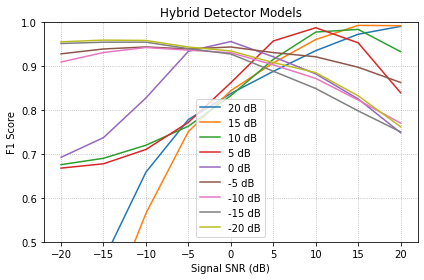

In [ ]:
model_snrs = [20, 15, 10, 5, 0, -5, -10, -15, -20]
test_snrs = [20, 15, 10, 5, 0, -5, -10, -15, -20]


f1_scores = {}
for model_snr in model_snrs:
    target = {}
    predicted = {}
    probabilities = {}

    for idx, snr in enumerate(test_snrs):
        conf = {}
        conf['f_s'] = 10_000
        conf['SNR'] = snr
        conf['batch_size'] = 8
        conf['epochs'] = 10
        conf['learning_rate'] = 0.0005
        conf['plot_confusion'] = True
        conf['model_path'] = f"{model_path}/hybrid-parallel-binary-model-{model_snr}.pt"

        testset_root = f"{radar_path}/{data_dir}/testset/{conf['f_s']}fs/{conf['SNR']}SNR"
        testds = ds.DatasetFolder( testset_root, dataloader, extensions=("npy",))
        testLoader = torch.utils.data.DataLoader( testds, conf["batch_size"], shuffle=True, num_workers=2)

        net = HybridRadarBinaryClassifier(conf).to(device)
        net.load_state_dict(torch.load(conf['model_path']))
        net.eval()

        correct = 0
        total = 0
        testloss = 0
        loss_fn = nn.CrossEntropyLoss().to(device)
        confm = np.zeros((2, 2), dtype=int)

        target[idx], predicted[idx], probabilities[idx] = evaluate_model(net, testLoader)

    f1_scores[model_snr] = calc_model_f1_scores(predicted, target)


fig = plt.figure(figsize=(6.0, 4.0), dpi=72)
ax = fig.add_subplot(111)
ax.grid(linestyle=':')
ax.grid(which='both', axis='x', linestyle=':')
_ = ax.set_ylim([0.5, 1.0])
ax.set_title("Hybrid Detector Models")
ax.set_xlabel("Signal SNR (dB)")
ax.set_ylabel("F1 Score")
for model_snr, snr_dict in f1_scores.items():
    _ = ax.plot(snr_dict.keys(), snr_dict.values(), label=f"{model_snr} dB")
_ = ax.legend()
fig.tight_layout()
plt.savefig(f"{plot_path}/hybrid_detector_f1_scores.eps")


### Generate an Ensemble of Model Evaluations

In [ ]:
import json

data_dir = "test_sets/binary/two_sided"
model_snr = -5
test_snrs = [20, 15, 10, 5, 0, -5, -10, -15, -20]
test_datasets = ["testset_0", "testset_1", "testset_2", "testset_3", "testset_4"]

print(f"Calculating F1 score ensemble for model SNR = {model_snr}")

f1_scores = {}
for test_dataset in test_datasets:
    target = {}
    predicted = {}
    probabilities = {}

    print(f"  Calculating F1 scores for testset = '{test_dataset}'")

    for idx, snr in enumerate(test_snrs):
        conf = {}
        conf['f_s'] = 10_000
        conf['SNR'] = snr
        conf['batch_size'] = 8
        conf['epochs'] = 10
        conf['learning_rate'] = 0.0005
        conf['plot_confusion'] = True
        conf['model_path'] = f"{model_path}/hybrid-parallel-binary-model-{model_snr}.pt"

        #print(f"    Calculating F1 scores for signal SNR = {snr}")
        testset_root = f"{radar_path}/{data_dir}/{test_dataset}/{conf['f_s']}fs/{conf['SNR']}SNR"
        testds = ds.DatasetFolder( testset_root, dataloader, extensions=("npy",))
        testLoader = torch.utils.data.DataLoader( testds, conf["batch_size"], shuffle=True, num_workers=2)

        net = HybridRadarBinaryClassifier(conf).to(device)
        net.load_state_dict(torch.load(conf['model_path']))
        net.eval()

        correct = 0
        total = 0
        testloss = 0
        loss_fn = nn.CrossEntropyLoss().to(device)
        confm = np.zeros((2, 2), dtype=int)

        target[idx], predicted[idx], probabilities[idx] = evaluate_model(net, testLoader)

    f1_scores[test_dataset] = calc_model_f1_scores(predicted, target)

f1_scores_file = f"{plot_path}/hybrid_model_snr{model_snr}_ensemble_f1_scores.json"
with open(f1_scores_file, 'w') as fd:
    json.dump(f1_scores, fd)

snr_list = [[snr for snr in d.keys()] for d in f1_scores.values()][0]
f1_arrays = [np.array(l) for l in [[d[snr] for d in f1_scores.values()] for snr in snr_list]]
f1_means = [np.mean(f1_array) for f1_array in f1_arrays]
f1_stddevs = [np.std(f1_array) for f1_array in f1_arrays]

print("\n\n")
print(f" Hybrid Detector for {model_snr}dB")
print("  SNR   Mean F1  F1 Std. dev.")
print("-----------------------------")
for i, snr in enumerate(snr_list):
    print(f"{snr:>5}: {f1_means[i]:7.3f}  {f1_stddevs[i]:9.6f}")


Calculating F1 score ensemble for model SNR = -5
  Calculating F1 scores for testset = 'testset_0'
  Calculating F1 scores for testset = 'testset_1'
  Calculating F1 scores for testset = 'testset_2'
  Calculating F1 scores for testset = 'testset_3'
  Calculating F1 scores for testset = 'testset_4'



 Hybrid Detector for -5dB
  SNR   Mean F1  F1 Std. dev.
-----------------------------
   20:   0.864   0.007030
   15:   0.892   0.004230
   10:   0.912   0.002256
    5:   0.930   0.004034
    0:   0.940   0.001978
   -5:   0.942   0.004057
  -10:   0.944   0.002178
  -15:   0.936   0.003713
  -20:   0.932   0.006611
